In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

#!pip install pandas matplotlib wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
import re
from typing import List, Dict



try:
    with open("D://Download//engFullText.txt", 'r', encoding='utf-8') as file:
        engFullText = file.read()
       # print(content)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Download the 'punkt' tokenizer models if not already present
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#Text cleaner removes digits, punctuation, and stop words
def clean_text(text):
    """
    Cleans a given text by:
    1. Lowercasing all characters.
    2. Removing digits.
    3. Removing punctuation.
    4. Removing stop words.
    """
    # 1. Lowercase the text
    text = text.lower()

    # 2. Remove digits
    text_without_digits = ''.join(char for char in text if not char.isdigit())

    # 3. Remove punctuation
    text_without_punctuation = ''.join(char for char in text_without_digits if char not in string.punctuation)

    # 4. Remove stop words
    # Download stopwords if not already downloaded
    try:
        stopwords_english = set(stopwords.words('english'))
    except LookupError:
        nltk.download('stopwords')
        stopwords_english = set(stopwords.words('english'))

    words = text_without_punctuation.split()
    filtered_words = [word for word in words if word not in stopwords_english]

    return ' '.join(filtered_words)

# Example usage:
engFullText = clean_text(engFullText)
#print(engFullText)

In [ ]:
#Sentence and words tokenizer
def segment_and_tokenize(text):
    """
    Segments a given text into sentences and then tokenizes each sentence into words.

    Args:
        text (str): The input text to process.

    Returns:
        list: A list of lists, where each inner list contains the words of a sentence.
    """
    sentences = sent_tokenize(text)
    tokenized_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        tokenized_sentences.append(words)
    return tokenized_sentences

# Example usage:
text = engFullText
result = segment_and_tokenize(text)
#print(result)

In [ ]:
# Prepare the Data For Counting
word_counts = Counter()
for sentence in result[0]:
    words = sentence.lower().split()  # Convert to lowercase and split into words
    word_counts.update(words)

#Get words and their frequencies
words = list(word_counts.keys())
frequencies = list(word_counts.values())



In [12]:
#Save Word Count
wordCountDict = {'Word': words,'Frequency': frequencies}

wordCountDf = pd.DataFrame(wordCountDict)
wordCountDf = wordCountDf.sort_values(by='Frequency', ascending = False)
wordCountDf = wordCountDf.drop(0)

wordCountDf.to_csv('wordCountDf.csv', index = False)

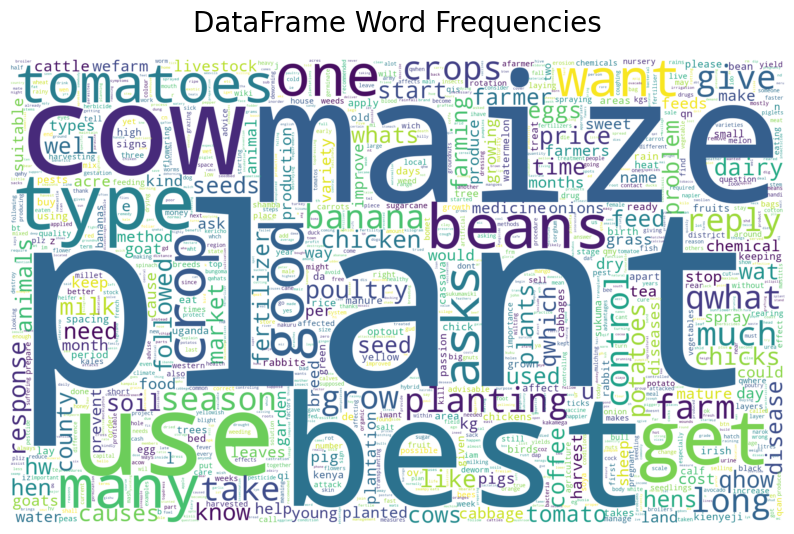

In [ ]:
#Word Cloud Generator
def generate_fancy_word_cloud(dataframe, text_col, freq_col, title="Fancy Word Cloud"):
    """
    Generates and displays a word cloud from a pandas DataFrame.

    Args:
        dataframe (pd.DataFrame): The input DataFrame.
        text_col (str): The name of the column containing the words.
        freq_col (str): The name of the column containing the frequencies/counts.
        title (str): The title for the plot.
    """
    # 1. Create a dictionary from the DataFrame columns
    # The wordcloud library expects a dictionary mapping {word: frequency}
    word_freq_dict = dict(zip(dataframe[text_col], dataframe[freq_col]))
    
    # Optional: Define custom stopwords if needed (or use default)
    # stopwords = set(STOPWORDS)
    # stopwords.update(["extra", "words", "to", "remove"])

    # 2. Configure the WordCloud object
    # Key parameters for a "fancy" look often include custom colors,
    # background color, max words, and font size scaling.
    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width=1000,
        height=600,
        prefer_horizontal=0.9, # Prefer horizontal text orientation
        colormap='viridis',    # A visually appealing color map
        # stopwords=stopwords,
        scale=2,               # Higher scale makes for better resolution
        contour_width=3, 
        contour_color='steelblue'
    )

    # 3. Generate the word cloud image from the frequency dictionary
    wc.generate_from_frequencies(word_freq_dict)

    # 4. Display the generated image
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off") # Hide the axis ticks and labels
    plt.title(title, fontsize=20, pad=20)
    plt.show()

    # Optional: Save the figure
    # wc.to_file("fancy_wordcloud.png")



df = wordCountDf

# 2. Call the function to generate the word cloud
generate_fancy_word_cloud(
    dataframe=df, 
    text_col='Word', 
    freq_col='Frequency',
    title="DataFrame Word Frequencies"
)


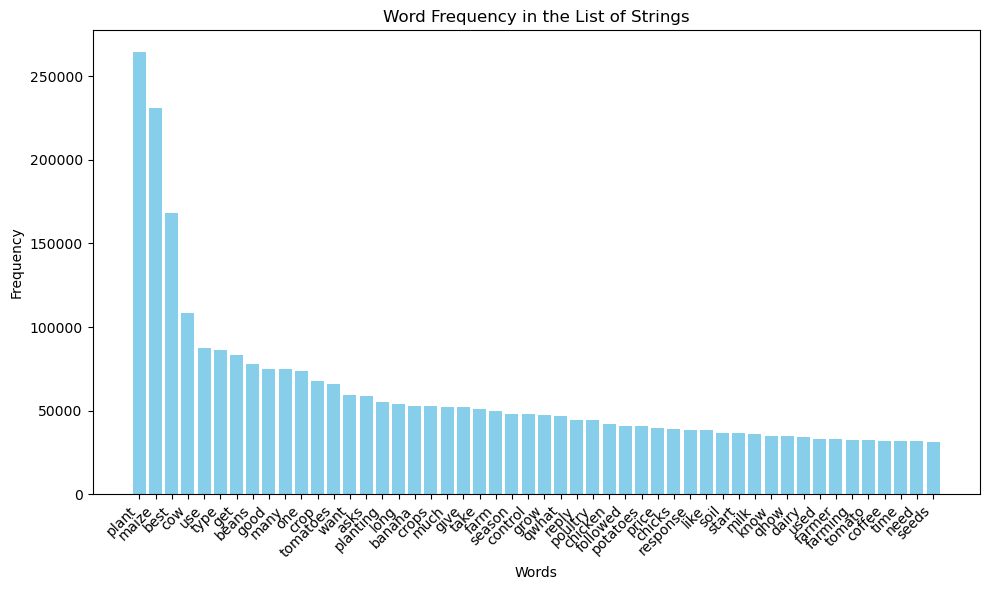

In [14]:
#Generate the Bar Graph
plt.figure(figsize=(10, 6)) # Adjust figure size for better visualization
plt.bar(wordCountDf['Word'][:50], wordCountDf['Frequency'][:50], color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency in the List of Strings")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [15]:
#If data needs to be reloaded
import pandas as pd
wordCountDf = pd.read_csv("wordCountDf.csv")


In [16]:
#Loading keywords
keyWords = wordCountDf['Word'][:50]

In [ ]:
def map_financial_terms_to_sources(text_list: List[str], financial_terms: List[str]) -> Dict[str, List[str]]:
    """
    Detects financial terms from a list of texts and maps each unique detected term
    (with original casing) back to the source text lines they appeared in.

    Args:
        text_list (List[str]): The list of text strings to analyze.
        financial_terms (List[str]): A list of financial terms (words or phrases) to detect.

    Returns:
        Dict[str, List[str]]: A dictionary where keys are the detected terms (original casing)
                              and values are lists of the source text lines.
    """
    # Use a dict with sets for values to manage sources without duplicates
    term_to_sources_map: Dict[str, set] = {}
    
    # Pre-process terms for regex: use case-insensitive search but store the original
    normalized_terms = [re.escape(term.lower()) for term in financial_terms]
    pattern_str = r'\b(' + '|'.join(normalized_terms) + r')\b'
    # Compile regex for efficient matching, ignoring case
    pattern = re.compile(pattern_str, re.IGNORECASE)

    for source_text in text_list:
        # Find all matches using the compiled case-insensitive pattern
        matches_with_case = pattern.findall(str(source_text))
        
        for matched_term_with_case in matches_with_case:
            # Initialize set if term is new
            if matched_term_with_case not in term_to_sources_map:
                term_to_sources_map[matched_term_with_case] = set()
            # Add the source text to the term's set of sources
            term_to_sources_map[matched_term_with_case].add(source_text)

    # Convert sets to lists for the final output format
    final_output: Dict[str, List[str]] = {
        term: sorted(list(sources)) for term, sources in term_to_sources_map.items()
    }
    return final_output

# Example usage
financial_terms_list = [
    "bull market",
    "bear market",
    "equity",
    "asset",
    "liability",
    "stock market",
    "portfolio",
    "ROI",
    "NASDAQ",
    "dividend",
    "loan",
    "market",
    "money",
    "checking account",
    "account",
    "savings",
    "credit card",
    "debit card",
    "card",
    "investment",
    "banking"
]

terms_and_sources = map_financial_terms_to_sources(wordCountDf['Word'], financial_terms_list)

# Print the final mapping
for term, sources in terms_and_sources.items():
    print(f"Detected Term: '{term}'")
    
"""    print("  Found in:")
    for source in sources:
        print(f"    - \"{source}\"")
    print("-" * 20)
"""

Detected Term: 'market'
Detected Term: 'money'
Detected Term: 'loan'
Detected Term: 'account'
Detected Term: 'investment'
Detected Term: 'card'
Detected Term: 'asset'
Detected Term: 'savings'
Detected Term: 'banking'
Detected Term: 'portfolio'
Detected Term: 'liability'
Detected Term: 'dividend'
Detected Term: 'equity'


'    print("  Found in:")\n    for source in sources:\n        print(f"    - "{source}"")\n    print("-" * 20)\n'

In [ ]:
#!pip install --upgrade pydantic
#!pip install spacy networkx matplotlib pandas
#!python -m spacy download en_core_web_lg
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import spacy

# Load English model
nlp = spacy.load("en_core_web_lg")

# Sample text data (replace with your own text corpus)
text = engFullText


In [ ]:

def create_keyword_frequency_graph(input_text, target_keyword, n_frequent=10):
    nlp.max_length = 10000000
    doc = nlp(input_text.lower()) # Process text in lowercase
    target_keyword_lower = target_keyword.lower()

    # Check if the target keyword is in the text
    if target_keyword_lower not in [token.text for token in doc]:
        print(f"Error: Target keyword '{target_keyword}' was not found in the provided text.")
        return

    # Use a dictionary to count co-occurrences
    co_occurrence_counts = defaultdict(int)

    # Iterate over sentences
    for sent in doc.sents:
        # Extract meaningful, unique words in the current sentence
        words_in_sentence = set()
        for token in sent:
            if token.is_alpha and not token.is_stop and len(token.text) > 2:
                words_in_sentence.add(token.lemma_)
        
        # Check if the target keyword is in this sentence
        if target_keyword_lower in words_in_sentence:
            # If yes, increment the count for every *other* word in that sentence
            for word in words_in_sentence:
                if word != target_keyword_lower:
                    co_occurrence_counts[word] += 1
    
    # Sort by frequency in descending order
    sorted_counts = sorted(co_occurrence_counts.items(), key=lambda item: item[1], reverse=True)
    most_frequent_words = sorted_counts[:n_frequent]

    print(f"Found {len(most_frequent_words)} most frequent words co-occurring with '{target_keyword}':")
    for word, count in most_frequent_words:
        print(f"- {word}: {count} occurrences")

    # --- Visualization ---
    G = nx.Graph()
    G.add_node(target_keyword_lower)
    
    for word, count in most_frequent_words:
        G.add_node(word)
        G.add_edge(target_keyword_lower, word, weight=count)

    plt.figure(figsize=(12, 10), facecolor='#f0f0f0')
    pos = nx.spring_layout(G, k=0.7, iterations=50, seed=42)
    
    # Node sizes based on frequency count
    counts = [count for word, count in most_frequent_words]
    node_sizes = [1500] + [count * 200 for count in counts]

    # Use a simple, clear color scheme (e.g., green scale)
    keyword_color = 'darkred'
    node_colors = ['#A0CBE2'] * len(counts) # All surrounding nodes same color for simplicity
    colors = [keyword_color] + node_colors

    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors='black')
    
    # Draw Edges (width based on frequency count)
    edge_widths = [count for word, count in most_frequent_words]
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_widths, alpha=0.7)
    
    # Draw Labels
    nx.draw_networkx_labels(G, pos, font_size=11, font_family='sans-serif', font_weight='bold')
    
    # Add Frequency Counts as labels on the edges
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=10)

    plt.title(f"Co-occurrence Frequency Graph with '{target_keyword}'", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Found 10 most frequent words co-occurring with 'loan':
- plant: 55 occurrences
- good: 48 occurrences
- maize: 45 occurrences
- farmer: 37 occurrences
- cow: 36 occurrences
- tomato: 36 occurrences
- use: 35 occurrences
- ask: 35 occurrences
- crop: 33 occurrences
- bean: 33 occurrences


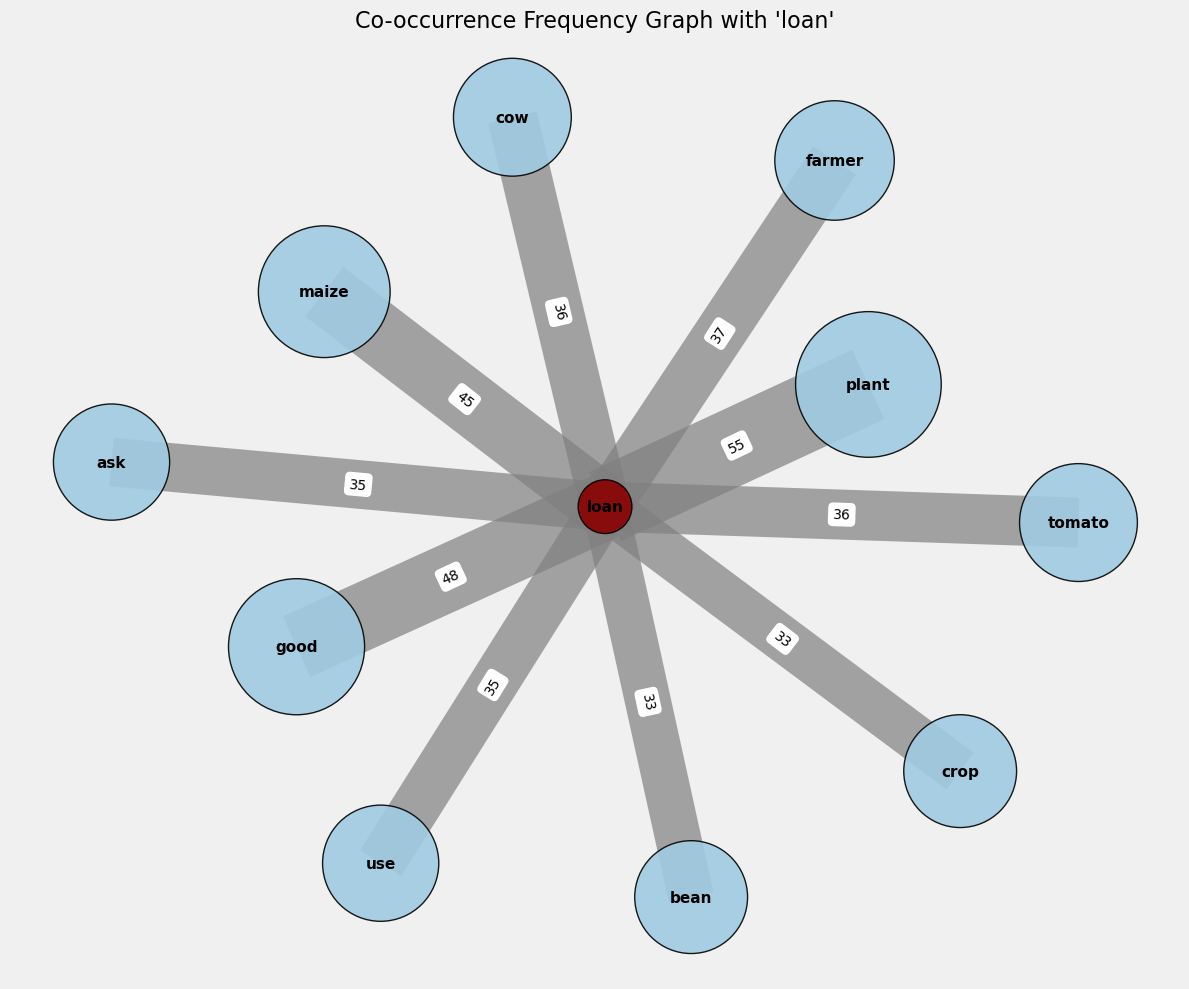

In [36]:
# --- USER INPUT SECTION ---

my_text = text[:2000000]
my_keyword = "loan" 

# --- EXECUTE THE FREQUENCY FUNCTION ---

create_keyword_frequency_graph(my_text, my_keyword, n_frequent=10)
